In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import os
import matplotlib.pyplot as plt

from maskclip_onnx import clip

import torch
import torchvision.transforms as T

class MaskCLIPFeaturizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.model, self.preprocess = clip.load(
            "ViT-B/16",
            download_root=os.getenv('TORCH_HOME', os.path.join(os.path.expanduser('~'), '.cache', 'torch'))
        )
        self.model.eval()
        self.patch_size = self.model.visual.patch_size

    def forward(self, img):
        b, _, input_size_h, input_size_w = img.shape
        patch_h = input_size_h // self.patch_size
        patch_w = input_size_w // self.patch_size
        features = self.model.get_patch_encodings(img).to(torch.float32)
        return features.reshape(b, patch_h, patch_w, -1).permute(0, 3, 1, 2)


In [2]:
input_size = 224

transform = T.Compose([
    T.Resize(input_size),
    # T.CenterCrop((input_size, input_size)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
from PIL import Image
import numpy as np

image = Image.open("/home/roger/Pictures/test_wrist.png").convert("RGB")

image_tensor = transform(image).unsqueeze(0).cuda()
print(image_tensor.shape)

torch.Size([1, 3, 224, 306])


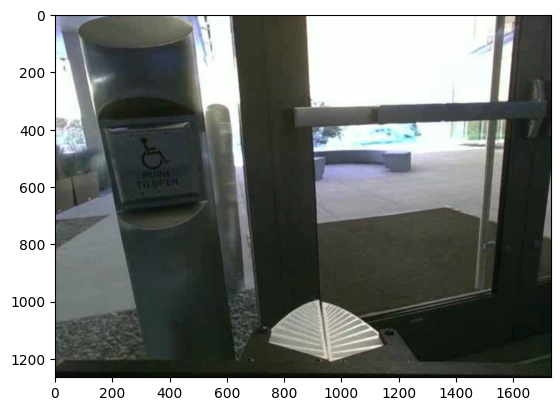

In [4]:
plt.imshow(image)

In [5]:
model = MaskCLIPFeaturizer().cuda()

In [6]:
results = model(image_tensor)
print(results.shape)

torch.Size([1, 512, 14, 19])


In [7]:
clip.tokenize

<function maskclip_onnx.clip.tokenize(texts: Union[str, List[str]], context_length: int = 77, truncate: bool = False) -> Union[torch.IntTensor, torch.LongTensor]>

In [8]:
text_query = "ADA push button"
text = clip.tokenize(text_query).to(results.device)
text_feats = model.model.encode_text(text).squeeze().to(torch.float32)
assert len(text_feats.shape) == 1

In [9]:
lr_sims = torch.einsum("chw,c->hw", F.normalize(results[0].to(torch.float32), dim=0), F.normalize(text_feats, dim=0))

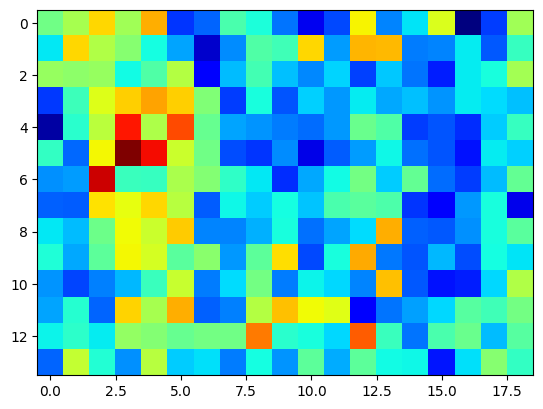

In [10]:
plt.imshow(lr_sims.cpu().detach().numpy(), cmap='jet', interpolation='nearest')

In [11]:
# jit tracing
test_tensor = torch.zeros_like(image_tensor)
model = model.eval()
model = torch.jit.trace(model, test_tensor)
torch.jit.save(model, "/tmp/maskclip_featurizer.pt")

/home/roger/b1_act/third_party/maskclip_onnx/maskclip_onnx/interpolate.py:20: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_patches == num_og_patches and w == h:
/home/roger/b1_act/third_party/maskclip_onnx/maskclip_onnx/interpolate.py:31: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert w0 * h0 == num_patches, "Number of patches does not match"
/home/roger/b1_act/third_party/maskclip_onnx/maskclip_onnx/interpolate.py:38: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data fl

In [12]:
test_model = torch.jit.load("/tmp/maskclip_featurizer.pt").cuda().eval()

In [13]:
(test_model(image_tensor) == model(image_tensor)).all()

tensor(True, device='cuda:0')

In [14]:
(test_model(test_tensor) == model(test_tensor)).all()

tensor(True, device='cuda:0')